In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
from osgeo import osr
from osgeo import ogr
from osgeo import gdal
from shapely.geometry import LineString, shape, mapping
import fiona
from shapely import affinity
import matplotlib.pyplot as plt
import traceback
import numpy as np
from rasterio.plot import show
import richdem as rd
import earthpy.spatial as es
import urllib
import rasterio as rio
import os
import math
import osmnx as ox
os.chdir(r'd:\work\leman')
import warnings
warnings.filterwarnings("ignore")

def export_raster(arr, name, transform, crs='epsg:4326'):
    new_dataset = rio.open(name, 'w', driver='GTiff',
                                height = arr.shape[0], width = arr.shape[1],
                                count=1, dtype=str(arr.dtype),
                                crs=crs,
                                transform=transform)

    new_dataset.write(arr, 1)
    new_dataset.close()

c:\Users\Airly\anaconda3\envs\ds_airly\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.representative_point(self.data), crs=self.crs)
c:\Users\Airly\anaconda3\envs\ds_airly\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
c:\Users\Airly\anaconda3\envs\ds_airly\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_oute

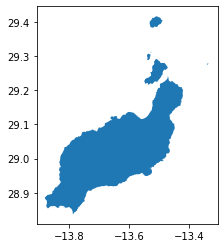

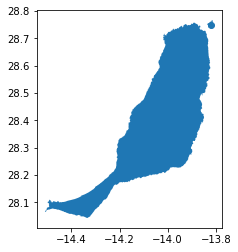

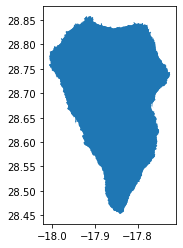

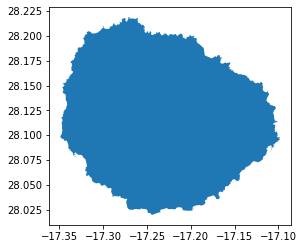

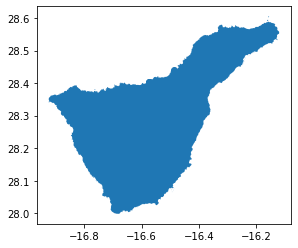

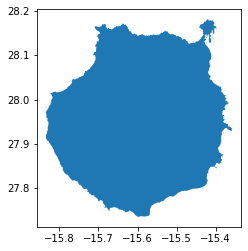

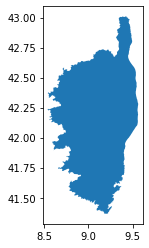

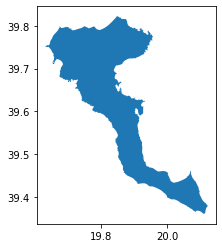

In [2]:
# TODO auto set params based on area
# TODO set uniform scale
# TODO clean temp files *shps, rasters
places = ['Lanzarote', 'Fuerteventura', 'La Palma', 'La Gomera',  'Tenerife', 'Gran Canaria', 'Corsica', 'Corfu']
crs_adequate = 'EPSG:3035' # idenfify automatically

for place in places:
        gdf = ox.geocode_to_gdf(place)
        islands = ox.geometries_from_place(place,  tags={"place": ["island", "islet"]})
        islands.plot()

In [3]:
places = ['Lanzarote', 'Fuerteventura', 'La Palma', 'La Gomera',  'Tenerife', 'Gran Canaria', 'Corsica', 'Corfu', 'Madera']
crs_adequate = 'EPSG:3035' # idenfify automatically
conNum=35

for place in places:
    try:
        gdf = ox.geocode_to_gdf(place)
        islands = ox.geometries_from_place(place,  tags={"place": ["island", "islet"]})
        islands.plot()

        west, south, east, north = islands.total_bounds 
        south, north, east, west = south - 0.2*(north-south), north + 0.2*(north-south), east - 0.2*(west-east), west + 0.2*(west-east)
        
        flat_areas_slope = 0.04 # flat areas - below this slope areas will not be drawn, teraz to kompletnie nie pasuje!
        folder_shp = r'.\shp'
        folder_res = r'.\results'

        url = fr'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL3&south={south}&north={north}&west={west}&east={east}&outputFormat=GTiff&API_Key=d216d4befdd891d39fc6db5b4ddf4a8e'
        raster_dem_path = fr".\files\dem_{place}.tif"
        urllib.request.urlretrieve(url, raster_dem_path)

        input_raster = gdal.Open(raster_dem_path)
        raster_dem_epsg_path = fr".\files\dem_epsg_{place}.tif"
        warp = gdal.Warp(raster_dem_epsg_path, input_raster, dstSRS=crs_adequate)
        warp = None # Closes the files
        input_raster = None

        with rio.open(raster_dem_epsg_path) as src:
            elevation = src.read(1)

        dem = rd.LoadGDAL(raster_dem_epsg_path)
        hillshade = es.hillshade(elevation)
        transform = src.transform
        raster_hs_path = fr'.\files\hs_{place}.tif'
        export_raster(hillshade, raster_hs_path, transform, crs=crs_adequate)

        slope = rd.TerrainAttribute(dem, attrib='slope_riserun')
        raster_slope_path = fr'.\files\slope_{place}.tif'
        export_raster(slope, raster_slope_path , transform, crs=crs_adequate)

        aspect = rd.TerrainAttribute(dem, attrib='aspect')
        raster_aspect_path = fr'.\files\aspect_{place}.tif'
        export_raster(aspect, raster_aspect_path, transform, crs=crs_adequate)

        raster_slope = rio.open(raster_slope_path)
        raster_aspect = rio.open(raster_aspect_path)
        raster_hs = rio.open(raster_hs_path)
        raster_dem = gdal.Open(raster_dem_epsg_path)
        fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))

        show((raster_slope, 1), ax=axb, cmap='YlOrBr', title='slope')
        show((raster_aspect, 1), ax=axg, cmap='jet', title='aspect', vmin=0)
        show((raster_hs, 1), ax=axr, cmap='gray', title='hillshade')

        rasterBand = raster_dem.GetRasterBand(1)
        proj = osr.SpatialReference(wkt=raster_dem.GetProjection())

        elevArray = rasterBand.ReadAsArray()
        demNan = -340282306073709652508363335590014353408.00
        demMax = elevArray.max()
        demMin = elevArray[elevArray!=demNan].min()

        print("Maximum dem elevation: %.2f, minimum dem elevation: %.2f"%(demMax,demMin))
        contourPath = f'{folder_shp}\contoursDefined_{conNum}_{place}.shp'
        contourDs = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contourPath)
        contourShp = contourDs.CreateLayer(str(conNum), proj)

        # TODO exclude -9 999 from slopes - from rasterio level??
        # define fields of id and elev
        fieldDef = ogr.FieldDefn("ID", ogr.OFTInteger)
        contourShp.CreateField(fieldDef)
        fieldDef = ogr.FieldDefn("elev", ogr.OFTReal)
        contourShp.CreateField(fieldDef)

        # define number of contours and range
        conList =[int(x) for x in np.linspace(demMin,demMax,conNum)]
        gdal.ContourGenerate(rasterBand, int(demMin), int(demMax), conList, 1, demNan, contourShp, 0, 1)

        contourDs.Destroy()
        contour_gdf = gpd.read_file(contourPath)
        line = fiona.open(contourPath)
        no_rows = len(line)

        west, south, east, north = contour_gdf.total_bounds
        area_island = int(((east-west)*(north-south))/10000)

        list_points = []
        station_meters = int(math.sqrt(area_island)/2)
        multiplier = int(math.sqrt(area_island))

        if multiplier > 250:
            multiplier = 250
        
        if station_meters <25:
            station_meters = 25

        if station_meters >200:
            station_meters = 200

        print(station_meters, multiplier)
        # TODO kreski - dluzsze? poziomice rzadziej?

        for feature in range(0, no_rows):
            try:
                points_st = (f'{folder_shp}/points_countur.shp')
                firstline = line.next()
                # transform to shapely geometry
                first = shape(firstline['geometry'])
                # length of the LineString
                length = first.length

                # creation of the resulting shapefile
                schema = {'geometry': 'Point','properties': {'id': 'int'},}
                with fiona.open(points_st, 'w', 'ESRI Shapefile', schema)  as output:
                    # create points every station_meters  along the line
                    for distance in range(0, int(length), station_meters):
                        point = first.interpolate(distance)
                        output.write({'geometry':mapping(point),'properties': {'id':1}})
                points_gdf = gpd.read_file(points_st)
                list_points.append(points_gdf)
                os.remove(f'{folder_shp}/points_countur.shp')
            except:
                pass

        station_points_merged = pd.concat(list_points)
        no_points = station_points_merged.shape[0]
        station_points_merged['x'] = station_points_merged['geometry'].apply(lambda p: p.x)
        station_points_merged['y'] = station_points_merged['geometry'].apply(lambda p: p.y)
        station_points_merged_path = fr'{folder_shp}/station_points_merged_{station_meters}.shp'
        station_points_merged.to_file(station_points_merged_path)
        station_points_merged = gpd.read_file(station_points_merged_path)
        station_points_merged['x'] = station_points_merged['geometry'].apply(lambda p: p.x)
        station_points_merged['y'] = station_points_merged['geometry'].apply(lambda p: p.y)

        gdf = gdf.to_crs(crs_adequate)
        station_points_merged = station_points_merged.set_crs(crs_adequate)
        station_points_merged = gpd.clip(station_points_merged, gdf)

        for idx, row in station_points_merged.iterrows():
            try:
                for val in raster_hs.sample([(row.x, row.y)]):
                    station_points_merged.at[idx, 'hs'] = val[0]
            except:
                pass
            try:
                for val in raster_aspect.sample([(row.x, row.y)]):
                    station_points_merged.at[idx, 'aspect'] = val[0]
            except:
                pass
            try:
                for val in raster_slope.sample([(row.x, row.y)]):
                        station_points_merged.at[idx, 'slope'] = val[0]
            except:
                pass

        station_points_merged = station_points_merged.dropna()
        station_points_merged = station_points_merged.loc[station_points_merged.slope > flat_areas_slope]
        station_points_merged_path = fr'{folder_shp}\points_slope_aspect_{conNum}_{station_meters}_{place}.shp'
        station_points_merged.to_file(station_points_merged_path)
        station_points_merged = gpd.read_file(station_points_merged_path)

        list_lines = []
        for point in station_points_merged.itertuples():
            try:
                input_l = LineString([(point.x - multiplier * point.slope, point.y), (point.x + multiplier * point.slope, point.y)])
                input_l_rot = affinity.rotate(input_l, point.aspect, (point.x, point.y))
                line_gs = GeoSeries(input_l_rot)
                line_gdf = gpd.GeoDataFrame(geometry=line_gs)
                line_gdf['hs'] = point.hs
                list_lines.append(line_gdf)
            except Exception as e:
                traceback.print_exc()

        gdf_lines = pd.concat(list_lines)
        line_width = 0.9
        transparency = 0.7
        fig, ax = plt.subplots(figsize=(20,15))
        hfont = {'fontname':'DejaVu Sans'}
        ax.set_title(place, fontsize=41, **hfont)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)

        gdf_lines.plot(ax = ax, column='hs', linewidth=line_width, alpha=transparency, cmap='gray', vmin=150, vmax=255)
        plt.savefig(fr'{folder_res}\l_{place}_{station_meters}_{multiplier}.jpg', dpi=300)
    except Exception as e:
        traceback.print_exc()


<>:64: DeprecationWarning: invalid escape sequence \c
<>:64: DeprecationWarning: invalid escape sequence \c
C:\Users\Airly\AppData\Local\Temp/ipykernel_16892/3488578042.py:64: DeprecationWarning: invalid escape sequence \c
  contourPath = f'{folder_shp}\contoursDefined_{conNum}_{place}.shp'
c:\Users\Airly\anaconda3\envs\ds_airly\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.representative_point(self.data), crs=self.crs)
c:\Users\Airly\anaconda3\envs\ds_airly\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
c:\Users\Airly\anaconda3\envs\ds_air

Maximum dem elevation: 669.00, minimum dem elevation: -25.00
200 250


C:\Users\Airly\AppData\Local\Temp/ipykernel_16892/3488578042.py:106: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  firstline = line.next()
C:\Users\Airly\AppData\Local\Temp/ipykernel_16892/3488578042.py:106: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  firstline = line.next()
C:\Users\Airly\AppData\Local\Temp/ipykernel_16892/3488578042.py:106: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  firstline = line.next()
C:\Users\Airly\AppData\Local\Temp/ipykernel_16892/3488578042.py:106: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  firstline = line.next()
C:\Users\Airly\AppData\Local\Temp/ipykernel_16892/3488578042.py:106: FionaDeprecationWarning: Collection.__next__() 

Maximum dem elevation: 788.00, minimum dem elevation: -11.00


Traceback (most recent call last):
  File "C:\Users\Airly\AppData\Local\Temp/ipykernel_16892/3488578042.py", line 66, in <module>
    contourShp = contourDs.CreateLayer(str(conNum), proj)
AttributeError: 'NoneType' object has no attribute 'CreateLayer'
c:\Users\Airly\anaconda3\envs\ds_airly\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.representative_point(self.data), crs=self.crs)
